Tugas Ekperimen 2 Natural Languange Processing

Klasifikasi Teks

IMAM PRAYOGA   	130119xxxx

SYAMSUL RIZAL 	130118xxxx


In [ ]:
import pandas as pd
import numpy as np
from time import time
import nltk
import re
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer , PorterStemmer
from nltk.corpus import stopwords
import seaborn as sns
import plotly.express as px
from sklearn import svm , model_selection, metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Eksplorasi Data

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/NLP/imdb.csv")
df.head()

,review,sentiment
0,"Okay, I know this does'nt project India in a g...",1
1,Despite John Travolta's statements in intervie...,0
2,"I am a kung fu fan, but not a Woo fan. I have ...",1
3,He seems to be a control freak. I have heard h...,0
4,"Admittedly, there are some scenes in this movi...",1


In [ ]:
#melihat distribusi label
fig = px.bar(df.groupby('sentiment').size().reset_index(name='count'), 
             x='sentiment', y='count', width=480, height=480, 
             barmode='group', title='Distribusi label')
fig.show(renderer='colab')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     10000 non-null  object
 1   sentiment  10000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 156.4+ KB


In [ ]:
# cek duplicated data
duplicates = df[df.duplicated()]
duplicates

,review,sentiment
1129,Is there any other time period that has been s...,0
3786,You do realize that you've been watching the E...,0
5532,Do we really need any more narcissistic garbag...,0
6101,"Beautiful film, pure Cassavetes style. Gena Ro...",1
7181,"Yes, in this movie you are treated to multiple...",0
7725,This is one of the best presentations of the 6...,1
7792,Being a HUGE fan of the bottom series i was re...,0
8035,This movie was NOTHING like the book. I think ...,0
8356,"As an avid Gone With the Wind fan, I was disap...",0
8613,This movie looked like it was rushed to releas...,0


In [ ]:
#drop dupliacate
df = df.drop_duplicates()

In [ ]:
# cek duplicated data
duplicates = df[df.duplicated()]
duplicates

,review,sentiment


In [ ]:
fig = px.bar(df.groupby('sentiment').size().reset_index(name='count'), 
             x='sentiment', y='count', width=480, height=480, 
             barmode='group', title='Distribusi label')
fig.show(renderer='colab')

In [ ]:
#mengecek data null
df.isnull().sum()

review       0
sentiment    0
dtype: int64

# Preprocessing

## Case Folding

In [ ]:
df['review'] = df['review'].str.lower()
df.head()

,review,sentiment
0,"okay, i know this does'nt project india in a g...",1
1,despite john travolta's statements in intervie...,0
2,"i am a kung fu fan, but not a woo fan. i have ...",1
3,he seems to be a control freak. i have heard h...,0
4,"admittedly, there are some scenes in this movi...",1


## Tokenizing & Removing Unwanted Char

In [ ]:
def remove_unwanted_char(text):
    # menghilangkan format html
    html_tag = re.compile(r'<.*?>')
    # menghilangkan format URL
    http_link = re.compile(r'https://\S+')
    www_link = re.compile(r'www\.\S+')
    # menghilangkan tanda baca
    punct = re.compile(r"[^\w\s]")
    # menghilangkan angka
    number = re.compile(r"\d")
    # menghilangkan double spasi
    space = re.compile(r"\s\s+")

    text = re.sub(html_tag, r" ", text)
    text = re.sub(http_link, r" ", text)
    text = re.sub(www_link, r" ", text)
    text = re.sub(punct, r" ", text)
    text = re.sub(number, r" ", text)
    text = re.sub(space, r" ", text)
    return text
                
df['review'] = df['review'].apply(remove_unwanted_char)

#remove number
def remove_number(text):
    return  re.sub(r"\d+", "", text)

df['review'] = df['review'].apply(remove_number)


#remove whitespace leading & trailing
def remove_whitespace_LT(text):
    return text.strip()

df['review'] = df['review'].apply(remove_whitespace_LT)

#remove multiple whitespace into single whitespace
def remove_whitespace_multiple(text):
    return re.sub('\s+',' ',text)


# NLTK word rokenize 
df['token'] = df['review'].apply(lambda x: word_tokenize(x))


df.head()

,review,sentiment,token
0,okay i know this does nt project india in a go...,1,"[okay, i, know, this, does, nt, project, india..."
1,despite john travolta s statements in intervie...,0,"[despite, john, travolta, s, statements, in, i..."
2,i am a kung fu fan but not a woo fan i have no...,1,"[i, am, a, kung, fu, fan, but, not, a, woo, fa..."
3,he seems to be a control freak i have heard hi...,0,"[he, seems, to, be, a, control, freak, i, have..."
4,admittedly there are some scenes in this movie...,1,"[admittedly, there, are, some, scenes, in, thi..."


## Stopword Removal

In [ ]:
stop_words = set(stopwords.words('english'))

In [ ]:
df['no_stopwords'] = df['token'].apply(lambda x: [word for word in x if word not in stop_words])
df.head()

,review,sentiment,token,no_stopwords
0,okay i know this does nt project india in a go...,1,"[okay, i, know, this, does, nt, project, india...","[okay, know, nt, project, india, good, light, ..."
1,despite john travolta s statements in intervie...,0,"[despite, john, travolta, s, statements, in, i...","[despite, john, travolta, statements, intervie..."
2,i am a kung fu fan but not a woo fan i have no...,1,"[i, am, a, kung, fu, fan, but, not, a, woo, fa...","[kung, fu, fan, woo, fan, interest, gangster, ..."
3,he seems to be a control freak i have heard hi...,0,"[he, seems, to, be, a, control, freak, i, have...","[seems, control, freak, heard, comment, losing..."
4,admittedly there are some scenes in this movie...,1,"[admittedly, there, are, some, scenes, in, thi...","[admittedly, scenes, movie, seem, little, unre..."


## Stemming

In [ ]:
# create stemmer
stemmer = PorterStemmer()
df['stemming'] = df['no_stopwords'].apply(lambda x: [stemmer.stem(word) for word in x])
df.head()

,review,sentiment,token,no_stopwords,stemming
0,okay i know this does nt project india in a go...,1,"[okay, i, know, this, does, nt, project, india...","[okay, know, nt, project, india, good, light, ...","[okay, know, nt, project, india, good, light, ..."
1,despite john travolta s statements in intervie...,0,"[despite, john, travolta, s, statements, in, i...","[despite, john, travolta, statements, intervie...","[despit, john, travolta, statement, interview,..."
2,i am a kung fu fan but not a woo fan i have no...,1,"[i, am, a, kung, fu, fan, but, not, a, woo, fa...","[kung, fu, fan, woo, fan, interest, gangster, ...","[kung, fu, fan, woo, fan, interest, gangster, ..."
3,he seems to be a control freak i have heard hi...,0,"[he, seems, to, be, a, control, freak, i, have...","[seems, control, freak, heard, comment, losing...","[seem, control, freak, heard, comment, lose, c..."
4,admittedly there are some scenes in this movie...,1,"[admittedly, there, are, some, scenes, in, thi...","[admittedly, scenes, movie, seem, little, unre...","[admittedli, scene, movi, seem, littl, unreali..."


## Lemmanization

In [ ]:
lemmatizer = WordNetLemmatizer()
df['lemmatize'] = df['stemming'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
df.head()

,review,sentiment,token,no_stopwords,stemming,lemmatize
0,okay i know this does nt project india in a go...,1,"[okay, i, know, this, does, nt, project, india...","[okay, know, nt, project, india, good, light, ...","[okay, know, nt, project, india, good, light, ...","[okay, know, nt, project, india, good, light, ..."
1,despite john travolta s statements in intervie...,0,"[despite, john, travolta, s, statements, in, i...","[despite, john, travolta, statements, intervie...","[despit, john, travolta, statement, interview,...","[despit, john, travolta, statement, interview,..."
2,i am a kung fu fan but not a woo fan i have no...,1,"[i, am, a, kung, fu, fan, but, not, a, woo, fa...","[kung, fu, fan, woo, fan, interest, gangster, ...","[kung, fu, fan, woo, fan, interest, gangster, ...","[kung, fu, fan, woo, fan, interest, gangster, ..."
3,he seems to be a control freak i have heard hi...,0,"[he, seems, to, be, a, control, freak, i, have...","[seems, control, freak, heard, comment, losing...","[seem, control, freak, heard, comment, lose, c...","[seem, control, freak, heard, comment, lose, c..."
4,admittedly there are some scenes in this movie...,1,"[admittedly, there, are, some, scenes, in, thi...","[admittedly, scenes, movie, seem, little, unre...","[admittedli, scene, movi, seem, littl, unreali...","[admittedli, scene, movi, seem, littl, unreali..."


## Final Clean data

In [ ]:
df["clean_title"] = df["lemmatize"].apply(lambda x: " ".join(x))
df.head()

,review,sentiment,token,no_stopwords,stemming,lemmatize,clean_title
0,okay i know this does nt project india in a go...,1,"[okay, i, know, this, does, nt, project, india...","[okay, know, nt, project, india, good, light, ...","[okay, know, nt, project, india, good, light, ...","[okay, know, nt, project, india, good, light, ...",okay know nt project india good light overal t...
1,despite john travolta s statements in intervie...,0,"[despite, john, travolta, s, statements, in, i...","[despite, john, travolta, statements, intervie...","[despit, john, travolta, statement, interview,...","[despit, john, travolta, statement, interview,...",despit john travolta statement interview favor...
2,i am a kung fu fan but not a woo fan i have no...,1,"[i, am, a, kung, fu, fan, but, not, a, woo, fa...","[kung, fu, fan, woo, fan, interest, gangster, ...","[kung, fu, fan, woo, fan, interest, gangster, ...","[kung, fu, fan, woo, fan, interest, gangster, ...",kung fu fan woo fan interest gangster movi fil...
3,he seems to be a control freak i have heard hi...,0,"[he, seems, to, be, a, control, freak, i, have...","[seems, control, freak, heard, comment, losing...","[seem, control, freak, heard, comment, lose, c...","[seem, control, freak, heard, comment, lose, c...",seem control freak heard comment lose control ...
4,admittedly there are some scenes in this movie...,1,"[admittedly, there, are, some, scenes, in, thi...","[admittedly, scenes, movie, seem, little, unre...","[admittedli, scene, movi, seem, littl, unreali...","[admittedli, scene, movi, seem, littl, unreali...",admittedli scene movi seem littl unrealist rav...


# Feature Extraction

## TF-IDF

In [ ]:
# tf-idf 
tfidf = TfidfVectorizer()
text_tfidf = tfidf.fit_transform(df['clean_title'].values.tolist())
text_tfidf.shape

(9982, 34804)

## Spilt data

In [ ]:
# membagi train test data (tfidf)
X = text_tfidf
y = df["sentiment"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X Train : ", (X_train.shape))
print("y Train : ", (y_train.shape))
print("X Test : ", (X_test.shape))
print("y Test : ", (y_test.shape))

X Train :  (7985, 34804)
y Train :  (7985,)
X Test :  (1997, 34804)
y Test :  (1997,)


# Klasifikasi

## Naive Bayes (Multinomial)

In [ ]:
# modelling dengan Multinomial Naive Bayes
start = time()
clf = MultinomialNB().fit(X_train, y_train)
predicted = clf.predict(X_test)
print('******** Multinomial Naive Bayes Classifier **********')
print('MultinomialNB Accuracy:', accuracy_score(y_test, predicted))
print('MultinomialNB Precision:', precision_score(y_test, predicted, average=None))
print('MultinomialNB Recall:', recall_score(y_test, predicted, average=None))
print('MultinomialNB f1_score:', f1_score(y_test, predicted, average=None))
print('Waktu untuk membangun model : {} detik'.format(round((time() - start))))

******** Multinomial Naive Bayes Classifier **********
MultinomialNB Accuracy: 0.8492739108662994
MultinomialNB Precision: [0.83580613 0.86308316]
MultinomialNB Recall: [0.8622449  0.83677483]
MultinomialNB f1_score: [0.84881969 0.84972541]
Waktu untuk membangun model : 0 detik


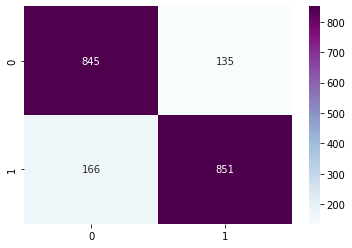

In [ ]:
# confusion matrix of Naive Bayes
cmrfc = confusion_matrix(y_test,predicted)
sns.heatmap(cmrfc,cmap='BuPu',annot=True,fmt='d')

In [ ]:
#clasification report Naive Bayes
print(classification_report(y_test, predicted))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       980
           1       0.86      0.84      0.85      1017

    accuracy                           0.85      1997
   macro avg       0.85      0.85      0.85      1997
weighted avg       0.85      0.85      0.85      1997



## Random Forest

In [ ]:
# Modelling dengan Random Forest
start = time()
rfc = RandomForestClassifier(random_state=0).fit(X_train,y_train)
predicted_rfc=rfc.predict(X_test)
print('******** Random Forest Classifier **********')
print('Random Forest Accuracy:', accuracy_score(y_test, predicted_rfc))
print('Random Forest Precision:', precision_score(y_test, predicted_rfc, average=None))
print('Random Forest Recall:', recall_score(y_test, predicted_rfc, average=None))
print('Random Forest f1_score:', f1_score(y_test, predicted_rfc, average=None))
print('Waktu untuk membangun model : {} menit'.format(round((time() - start) / 60, 2)))

******** Random Forest Classifier **********
Random Forest Accuracy: 0.8312468703054582
Random Forest Precision: [0.83594566 0.82692308]
Random Forest Recall: [0.81632653 0.84562439]
Random Forest f1_score: [0.82601962 0.83616918]
Waktu untuk membangun model : 0.25 menit


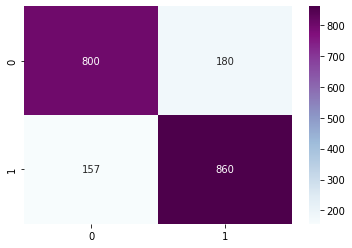

In [ ]:
# confusion matrix of Random Forest
cmrfc = confusion_matrix(y_test,predicted_rfc)
sns.heatmap(cmrfc,cmap='BuPu',annot=True,fmt='d')

In [ ]:
#clasification report Random Forest
print(classification_report(y_test, predicted_rfc))

              precision    recall  f1-score   support

           0       0.84      0.82      0.83       980
           1       0.83      0.85      0.84      1017

    accuracy                           0.83      1997
   macro avg       0.83      0.83      0.83      1997
weighted avg       0.83      0.83      0.83      1997



## SVM

In [ ]:
start = time()
SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train,y_train)
predictions_SVM = SVM.predict(X_test)
print('******** SVM **********')
print('SVM Accuracy:', accuracy_score(y_test, predictions_SVM))
print('SVM Precision:', precision_score(y_test, predictions_SVM, average=None))
print('SVM Recall:', recall_score(y_test, predictions_SVM, average=None))
print('SVM f1_score:', f1_score(y_test, predictions_SVM, average=None))
print('Waktu untuk membangun model : {} menit'.format(round((time() - start) / 60, 2)))

******** SVM **********
SVM Accuracy: 0.8728092138207311
SVM Precision: [0.88291139 0.86367969]
SVM Recall: [0.85408163 0.89085546]
SVM f1_score: [0.86825726 0.87705712]
Waktu untuk membangun model : 0.79 menit


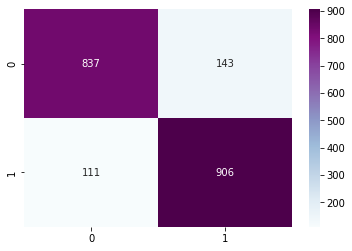

In [ ]:
# confusion matrix of SVM
cmrfc = confusion_matrix(y_test,predictions_SVM)
sns.heatmap(cmrfc,cmap='BuPu',annot=True,fmt='d')

In [ ]:
#clasification report Random Forest
print(classification_report(y_test, predictions_SVM))

              precision    recall  f1-score   support

           0       0.88      0.85      0.87       980
           1       0.86      0.89      0.88      1017

    accuracy                           0.87      1997
   macro avg       0.87      0.87      0.87      1997
weighted avg       0.87      0.87      0.87      1997



# Kesimpulan

In [ ]:
print('******** CONCLUSION **********')
print('MultinomialNB Accuracy:', accuracy_score(y_test, predicted))
print('Random Forest Accuracy:', accuracy_score(y_test, predicted_rfc))
print('SVM Accuracy:', accuracy_score(y_test, predictions_SVM))

******** CONCLUSION **********
MultinomialNB Accuracy: 0.8492739108662994
Random Forest Accuracy: 0.8312468703054582
SVM Accuracy: 0.8728092138207311
